# Purpose

This notebook serves as a documentation of my work through Chapter 10 of [Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291).  This chapter is an introduction to Artificial Neural Networks (ANN) using Keras and Tensorflow.

# Playground

First and foremost, the [Tensorflow Playground](https://playground.tensorflow.org) is a great place to gain some intuition about how ANNs work.  You can change hyperparameters live and see the effect in real time on the output, training, loss, etc.  You can also view each individual weight and output.  

In [2]:
import tensorflow as tf
from tensorflow import keras

print("tf version:", tf.__version__, ", keras version:", keras.__version__)



2023-02-01 16:11:31.956658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version: 2.10.0 , keras version: 2.10.0


# Dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset will be used throughout these examples.  It is a collection of clothing images that belong to 10 different classes.  It is similar to the more common [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, except it is more complex than hand-written images.  It can be loaded directly from `keras`.

Below, Im loading the dataset, splitting off a validation set, and normalizing the values.  Then, I'm defining the classes and printing out 4 random examples of each class.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print("Train shape: ", X_train.shape, ", data type: ", X_train.dtype)
print("Valid shape: ", X_valid.shape, ", data type: ", X_valid.dtype)
print("Test shape: ", X_test.shape, ", data type: ", X_test.dtype)



Train shape:  (55000, 28, 28) , data type:  float64
Valid shape:  (5000, 28, 28) , data type:  float64
Test shape:  (10000, 28, 28) , data type:  uint8


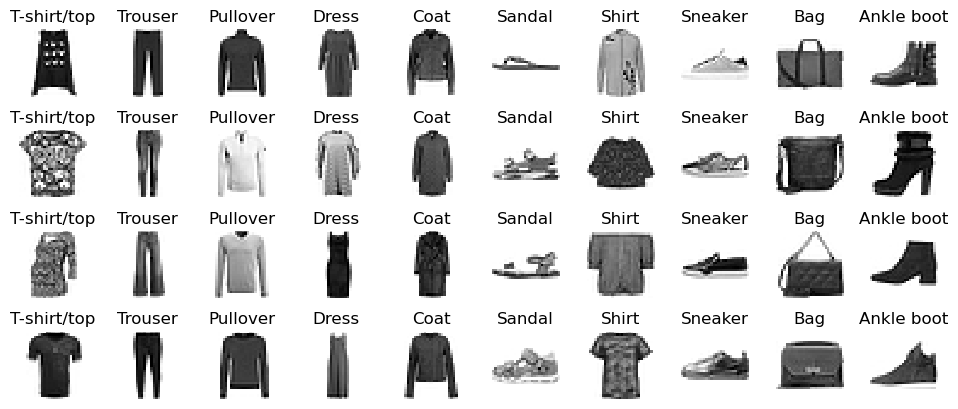

In [4]:
import matplotlib.pyplot as plt
import numpy as np

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

n_rows = 4
n_cols = len(class_names)
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        fig_index = n_cols * row + col + 1
        class_index = col
        X_subset = X_train[y_train == class_index]
        plt.subplot(n_rows, n_cols, fig_index)
        plt.imshow(
            X_subset[np.random.choice(X_subset.shape[0]), :],
            cmap="binary",
            interpolation="nearest",
        )
        plt.axis("off")
        plt.title(class_names[class_index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


# Image Classifier using Sequential API

## Define Layers and Connections

Here we will build a model using the sequential API, which is the simplest method of building an ANN using `keras`.  As it's name suggests, you simply define each layer sequentially to build the network from start to finish, defining the type of layer, number of nodes, and activation function for each.  The model below begins with a `Flatten` layer which simply takes the 28 x 28 images and flatten them down into 1-d.  The next three layers are `Dense` meaning they are fully connected.  The final layer uses a softmax activation because the final classes are exclusive.

In [5]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


2023-02-01 16:11:49.677420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Notice that the first layer has 235,500 parameters which is (28 * 28) * 300 connection weights plus 300 bias terms.  Dense layers have many parameters because they're fully connected which makes them very flexible but also prone to overfitting.  All layer information is available by accessing the layer directly, as seen below.  Notice the weights are initilized randomly which is necessary to break symmetry.  The initialization method can be changed by setting the `kernal_initializer`.  If the input shape is not specified when building the model above, then the shape of the weight matrix is not known and Keras will not initialize the weights until it knows the input shape. 

In [6]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
print(
    f"""
layer name: {hidden1.name}
first 20 weights: {weights[0:20,0]}
weights shape: {weights.shape}
first 20 biases: {biases[0:20]}
biases shape: {biases.shape}
"""
)




layer name: dense
first 20 weights: [-0.02355784 -0.03212263 -0.03922054 -0.01407871  0.00639102 -0.0551383
 -0.05833673 -0.06058538 -0.06544456 -0.00066341 -0.00740957 -0.03174374
 -0.04762195  0.04638626 -0.02782007 -0.01857707  0.05502741 -0.01643534
 -0.06210899 -0.00491448]
weights shape: (784, 300)
first 20 biases: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
biases shape: (300,)



## Compile the Model

Now I need to compile the model and specify the loss function, optimizer, and any additional metrics to be evaluated during training.  Note that it's important to tune the learning rate, so usually you'd want to specify it when compiling, e.g. `optimizer=keras.optimizers.SGD(lr=???)` and not simply use the default value of 0.01.

In [7]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)


## Train and Evaluate the Model

Training the model is as simple as calling the `fit` method along with supplying the training data, validation data, and number of training epochs.  Instead of supplying the validation set, you could also set `validation_split` to the desired ratio.  

In [8]:
history = model.fit(X_train, y_train, epochs=30, validation_data=[X_valid, y_valid])


Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6956 - accuracy: 0.7723 - val_loss: 0.5228 - val_accuracy: 0.8164
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4826 - accuracy: 0.8319 - val_loss: 0.5116 - val_accuracy: 0.8140
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4385 - accuracy: 0.8453 - val_loss: 0.4169 - val_accuracy: 0.8576
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4124 - accuracy: 0.8540 - val_loss: 0.4098 - val_accuracy: 0.8608
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3918 - accuracy: 0.8609 - val_loss: 0.3973 - val_accuracy: 0.8626
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3756 - accuracy: 0.8665 - val_loss: 0.3798 - val_accuracy: 0.8684
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3630 - accuracy: 0.8708 - val_loss: 0.3711 - val_accuracy:

The `fit` method returns a history object which contains the metrics evaluated per epoch, among other things.  Below, I'll use it to plot the learning curve to evaluate the model.  In this case, it looks like the model has not yet converged, as the loss appears to be still declining so I'd run the `fit` method again to train through some more epochs.  Here is where I would also tune hyperparameters to further improve model performance, including at least the following:
- learning rate
- optimizer
- number of layers
- number of neurons per layer
- activation functions per layer
- batch size

It's also important to re-tune the learning rate after changing any other hyperparameters. For the sake of this simple example, however, I won't proceed with any tuning.

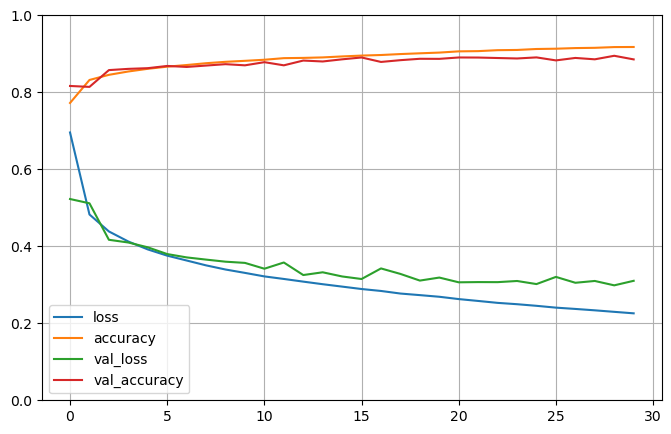

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


To evaluate on the test set, simply use the `evaluate` method.

In [10]:
model.evaluate(X_test, y_test)


313/313 [==============================] - 1s 2ms/step - loss: 62.4037 - accuracy: 0.8509


[62.40373611450195, 0.8508999943733215]

## Predict

To predict on new examples, simply use the `predict` method.  We don't have any new examples to predict on, so I'll just use the first three examples from the test set below.  In this case, the model predicted all three classes correctly.

In [11]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(5)


1/1 [==============================] - 0s 94ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
y_pred = np.argmax(y_proba, axis=1)
np.array(class_names)[y_pred]


array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

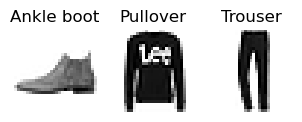

In [13]:
n_cols = X_new.shape[0]
plt.figure(figsize=(1.2 * n_cols, 1.2))
for col in range(n_cols):
    plt.subplot(1, n_cols, col + 1)
    plt.imshow(X_new[col], cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[col]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


# Regression MLP Using the Sequential API

Now I'm going to use the sequential API to build a regression MLP using the California Housing dataset, loaded from `sklearn`.  The main differences for the regression task include:
- Output layer is a single neuron since the MLP will be predicting a single value
- Output layer uses no activation function since the values should be unbounded
- Loss function is mean squared error
- To reduce the risk of overfitting, I'll use a single hidden layer with fewer neurons than before



In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

housing.feature_names


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [15]:
pd.DataFrame(X_train, columns=housing.feature_names).describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000
mean,3.860647,28.706718,5.425845,1.097572,1419.024978,2.961532,35.637674,-119.573775
std,1.908639,12.556697,2.669024,0.532408,1119.978128,2.340273,2.133999,1.995924
min,0.499900,1.000000,0.846154,0.500000,8.000000,1.066176,32.540000,-124.350000
25%,2.551800,18.000000,4.431414,1.005865,784.000000,2.433858,33.940000,-121.790000
50%,3.529100,29.000000,5.222537,1.048627,1163.000000,2.824859,34.260000,-118.500000
75%,4.736100,37.000000,6.039893,1.098278,1719.000000,3.287556,37.710000,-118.020000
max,15.000100,52.000000,141.909091,34.066667,28566.000000,230.172414,41.950000,-114.310000


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [17]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1),
    ]
)
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))



Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7619 - val_loss: 1.6223
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5180 - val_loss: 4.7467
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5418 - val_loss: 4.6420
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4770 - val_loss: 2.5154
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4435 - val_loss: 0.4217
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5062 - val_loss: 1.1203
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4889 - val_loss: 0.4181
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3993 - val_loss: 0.4084
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5408 - val_loss: 0.4121
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3981 - val_loss: 0.4031

In [18]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

print("Test MSE: ", round(mse_test, 4))


1/1 [==============================] - 0s 56ms/step
Test MSE:  0.36


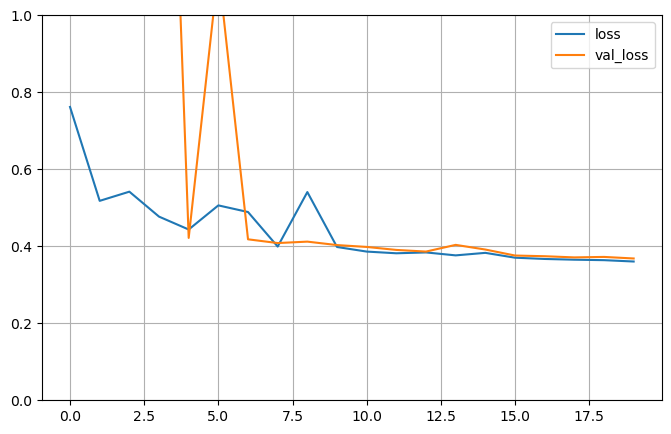

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


# Building More Complex Models Using the Functional API

To build a model that is not sequential, you have to use the funcitonal API.  Here, I'll build one such non-sequential model, the [Wide & Deep](https://arxiv.org/abs/1606.07792) neural network, which connects all or part of the input directly to the output layer.  This is intended to train simple rules in addition to the deep patterns.  A sequential MLP forces all data through each layer, which could then distort simple rules.  I'll revisit the above regression model on the California housing dataset.

The steps of constructing the model look a bit different with the functional API and so I'll explain each line here:
1.  Create an input object with defined input shape, using `input_` to avoid overwriting the built in python `input()` function.
2.  Define the first hidden layer, a dense layer with 30 neurons, RELU activation function, and pass it the preceeding layer `input_` like a function, e.g. functional API.
3.  Define the second hidden layer, also a dense layer with 30 neurons, RELU acitvation function, and pass it the preceeding layer `hidden1`.
4.  Create a concatenate layer to concatenate the input with the output of the second hidden layer.  This is the wide & deep part.
5.  Create an output layer with a single nueron and no activation function.
6.  Create a `keras` model by supplying the inputs and outputs as defined above.



In [20]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])


In [21]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.004))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20


/Users/mcnewcp/code/ann-intro/.env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


363/363 [==============================] - 1s 2ms/step - loss: 1.1130 - val_loss: 19.9629
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6658 - val_loss: 41.9549
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 2.4872 - val_loss: 8.4429
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6639 - val_loss: 17.1360
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 1.2588 - val_loss: 31.0927
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8575 - val_loss: 16.5131
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 1.0010 - val_loss: 10.0934
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6085 - val_loss: 5.3788
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6031 - val_loss: 2.7717
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4648 - val_loss: 1.5062
Epoc

In [22]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

print("Test MSE: ", round(mse_test, 4))


1/1 [==============================] - 0s 59ms/step
Test MSE:  0.3766


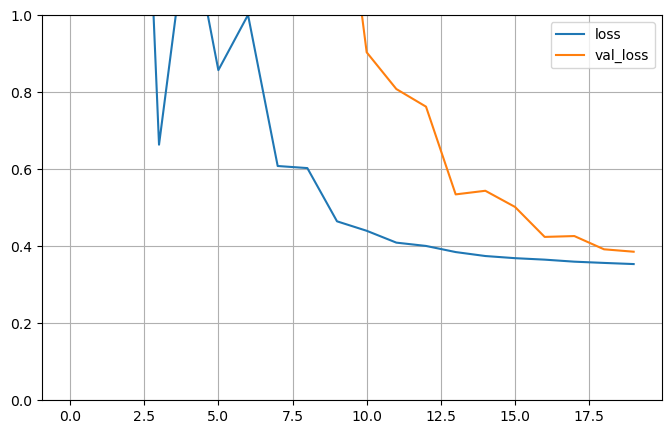

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## Multiple Inputs

It is also possible to supply multiple inputs to the model if you wanted to, for example, send a subset of features through the wide path and a different subset (possibly overlapping) subset through the deep path, it's as simple as defining those inputs and applying accordingly.  

Here, I'll modify the above model to use two overlapping subsets of inputs.  The first subset (`input_A`, features 1-5) will go through the wide path and the second subset (`input_B`, features 4-8) will go through the deep path.  It's also good practice to name at least the important layers for clarity.


In [24]:
input_A = keras.layers.Input(shape=X_train[:, :5].shape[1:], name="wide_input")
input_B = keras.layers.Input(shape=X_train[:, 4:].shape[1:], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([hidden2, input_A])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))



Since the model is designed to look for `[input_A, input_B]`, when calling the fit method, the training data will need to be supplied in a tuple format, e.g. `(X_train_A, X_train_B)`. The same is true for the validation, test, and predictions sets.

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.6790 - val_loss: 1.9307
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9139 - val_loss: 0.8500
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6900 - val_loss: 0.6587
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6127 - val_loss: 0.5953
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5679 - val_loss: 0.5535
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5335 - val_loss: 0.5228
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5066 - val_loss: 0.5005
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4864 - val_loss: 0.4849
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4718 - val_loss: 0.4736
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4608 - val_loss: 0.4657

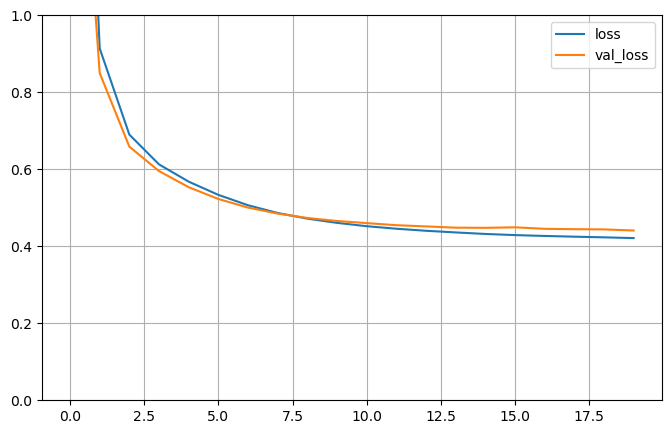

In [25]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 4:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 4:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 4:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit(
    (X_train_A, X_train_B),
    y_train,
    epochs=20,
    validation_data=((X_valid_A, X_valid_B), y_valid),
)

mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))
print("Test MSE: ", round(mse_test, 4))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## Multiple Outputs

There are a number of scenarios where predicting multiple outputs would be beneficial.  
- The most obvious to me include simultaneously locating and classifying one or more objects within a picture.  This would include a regressiont task with one output each for the x and y position, along with a classification of the object.  
- You could of course need to predict multiple targets from the same dataset, like more than one trait from a genetic dataset.  
- Another use case mentioned by the authors of [Hands on ML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is to use an additional output as a regularization technique.  For example, in the above model we could add an auxiliary output from the deep path only, which would be trained on the same target as the main output.  This would ensure that the deep path actually learns something on it's own, independent of the rest of the network, and therefore allow the model to generalize better.  

Adding additional outputs is quite simple, following the example above.


In [26]:
input_A = keras.layers.Input(shape=X_train[:, :5].shape[1:], name="wide_input")
input_B = keras.layers.Input(shape=X_train[:, 4:].shape[1:], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([hidden2, input_A])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])


### Losses and Weighted Loss

Each output needs to be assigned a loss function, which in our example will be MSE for both.  By default Keras will simply add the losses together to get our overall loss, but in our case we care more about the loss associated with the main output than that of the auxiliary output.  Thankfully, we can pass a list of weights for the outputs when compiling the model.  In this case we will pass `loss_weights[0.9, 0.1]` to inform Keras that we care about the main output much more than the auxiliary.